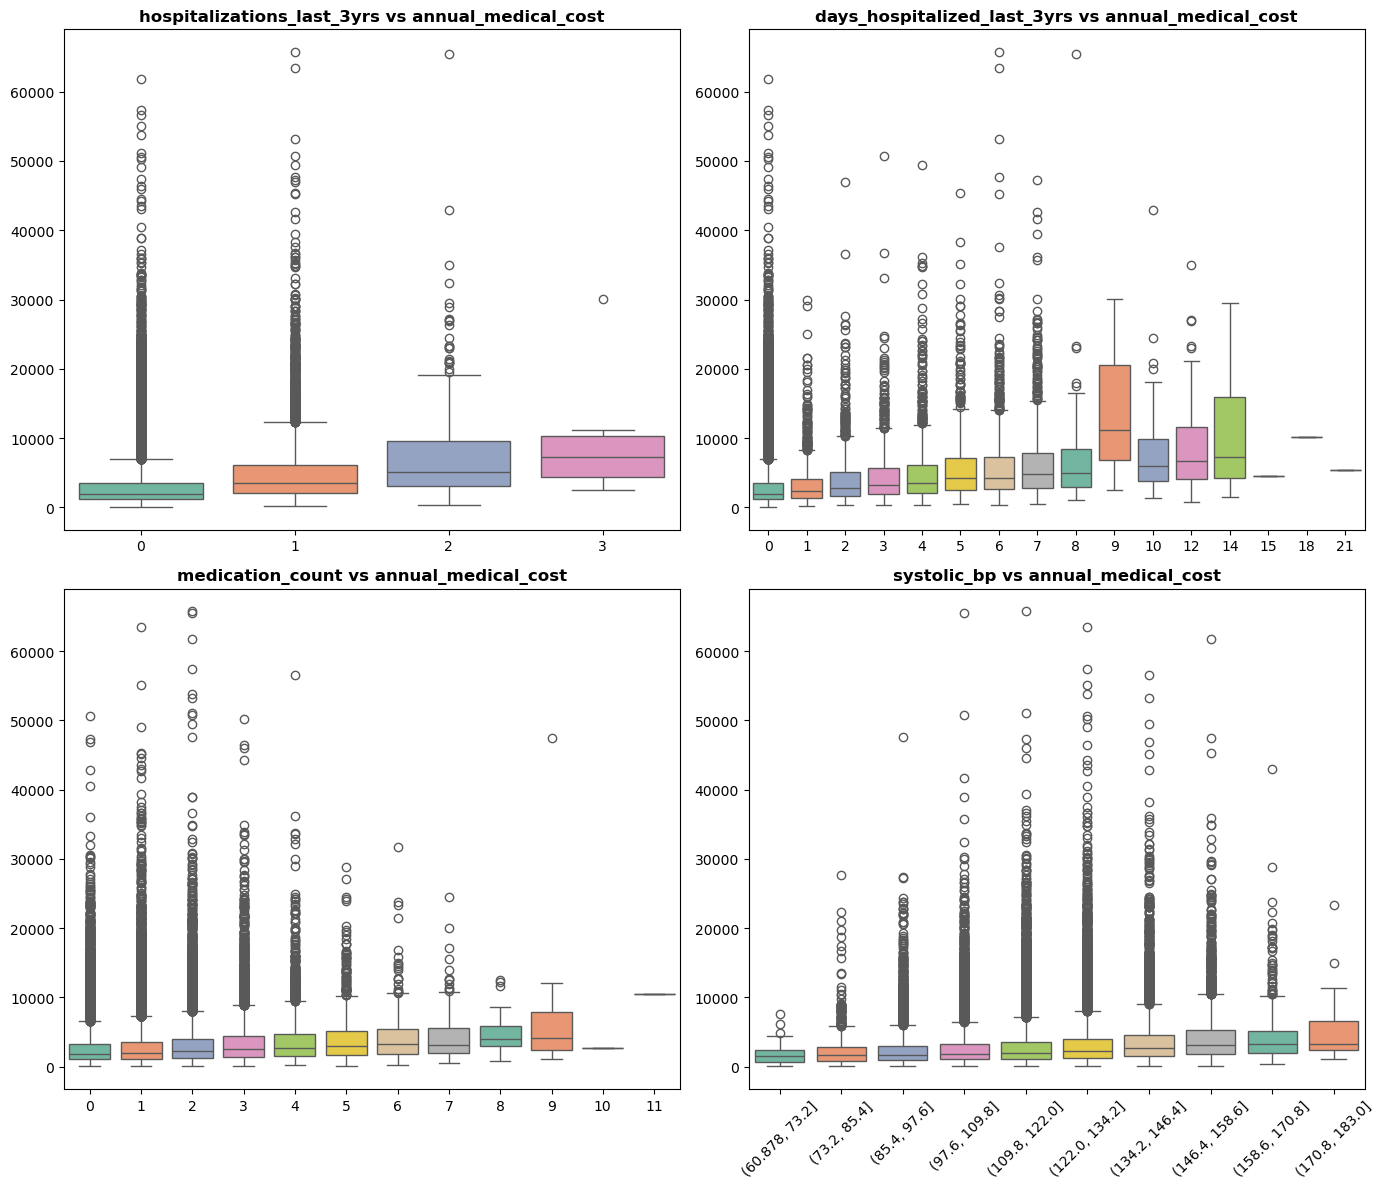

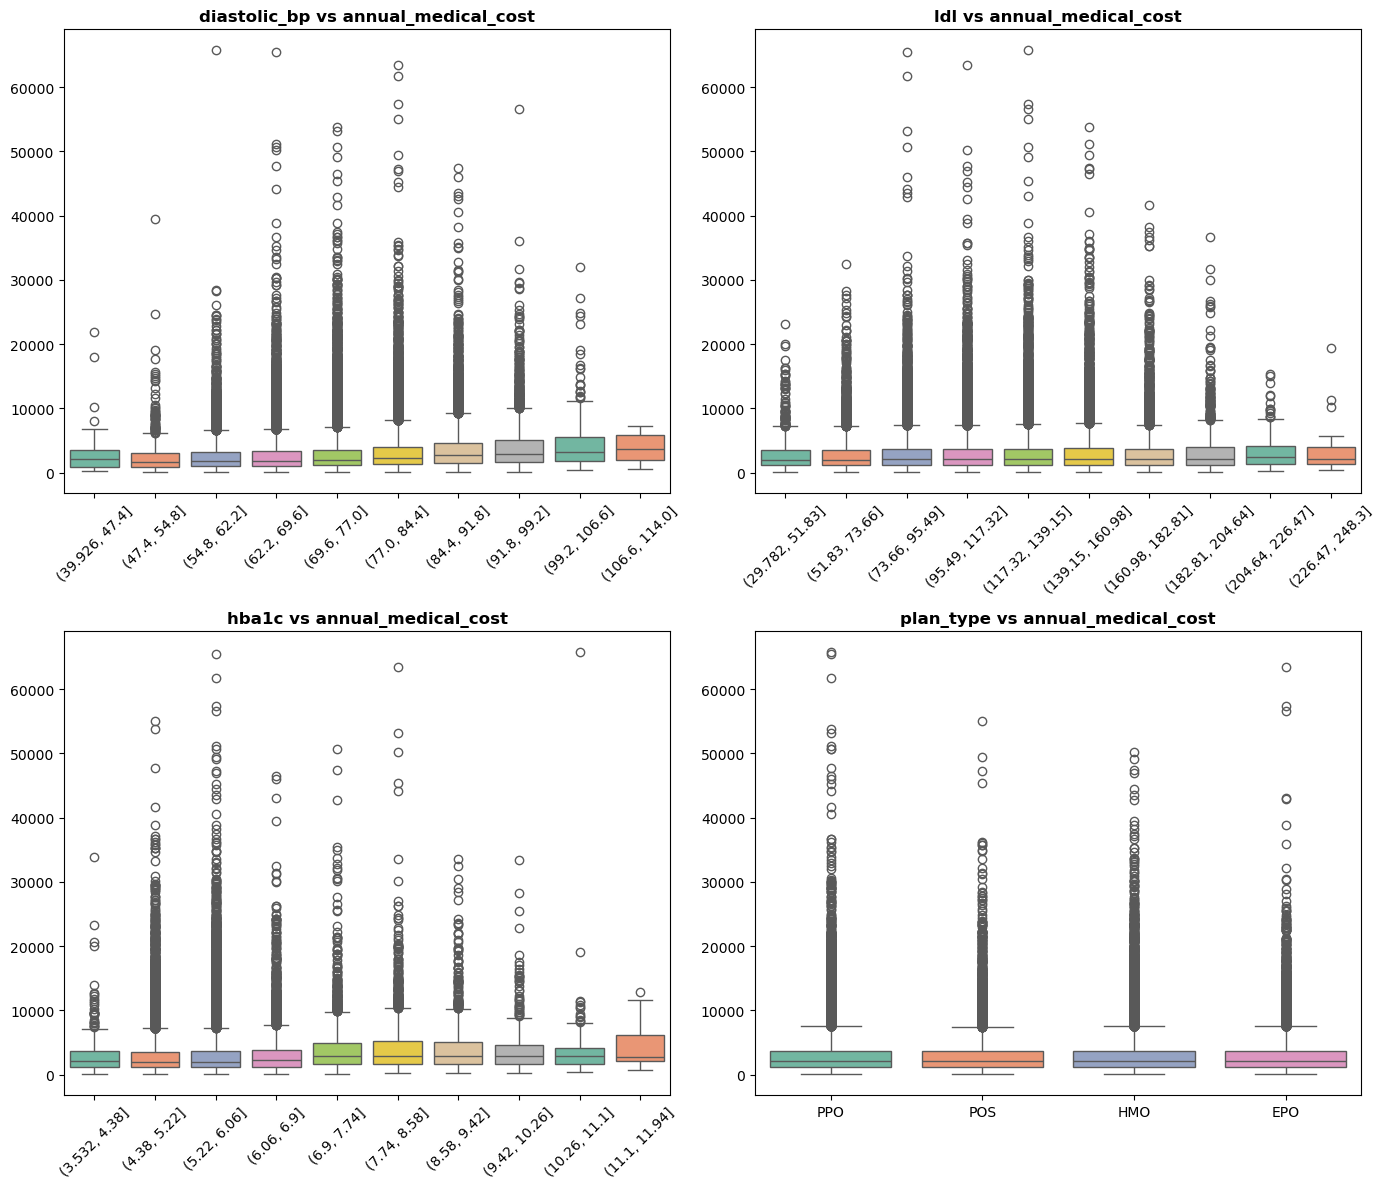

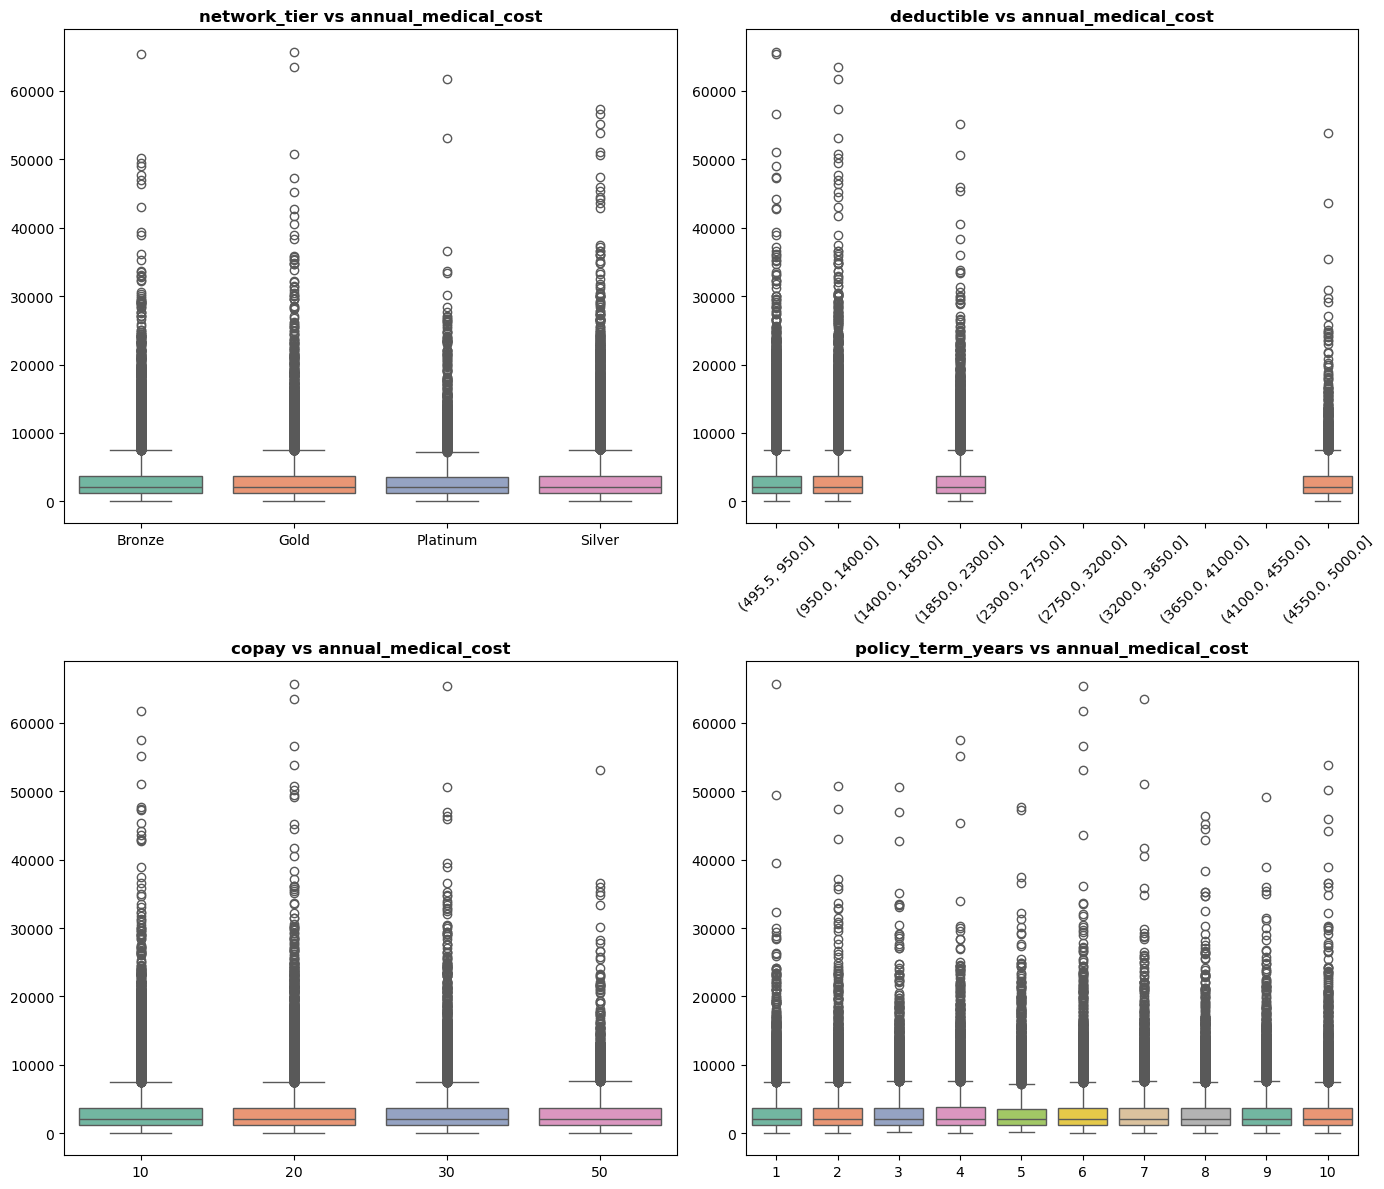

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

df = pd.read_csv('medical_insurance.csv')

columns = [
    "hospitalizations_last_3yrs", "days_hospitalized_last_3yrs", "medication_count", "systolic_bp",
    "diastolic_bp", "ldl", "hba1c", 
    "plan_type", "network_tier", "deductible",
    "copay", "policy_term_years", "policy_changes_last_2yrs"
]

target = "annual_medical_cost"

categorical_cols = [  "hospitalizations_last_3yrs", "days_hospitalized_last_3yrs", "medication_count", 
                    "plan_type","network_tier", "policy_changes_last_2yrs",
                    "copay",
                    "policy_term_years", "policy_changes_last_2yrs"]
numerical_cols = [col for col in columns if col not in categorical_cols]

def plot_batch(batch_cols, batch_number):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    for i, col in enumerate(batch_cols):
        ax = axes[i]
        if col in categorical_cols:
            sns.boxplot( x=col,y=target,hue=col,data=df,ax=ax,palette="Set2",dodge=False,legend=False)
        else:
           # Bin the continuous variable
           df[f'{col}_bin'] = pd.cut(df[col], bins=10)
           
           sns.boxplot(x=pd.cut(df[col], bins=10), y=target, hue=pd.cut(df[col], bins=10), data=df, ax=ax, palette="Set2", dodge=False, legend=False); plt.setp(ax.get_xticklabels(), rotation=45)

           plt.setp(ax.get_xticklabels(), rotation=45)

        
        ax.set_title(f'{col} vs {target}', fontsize=12, fontweight='bold')
        ax.set_xlabel('')
        ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()

plot_batch(columns[0:4], 1)
plot_batch(columns[4:8], 2)
plot_batch(columns[8:12], 3)


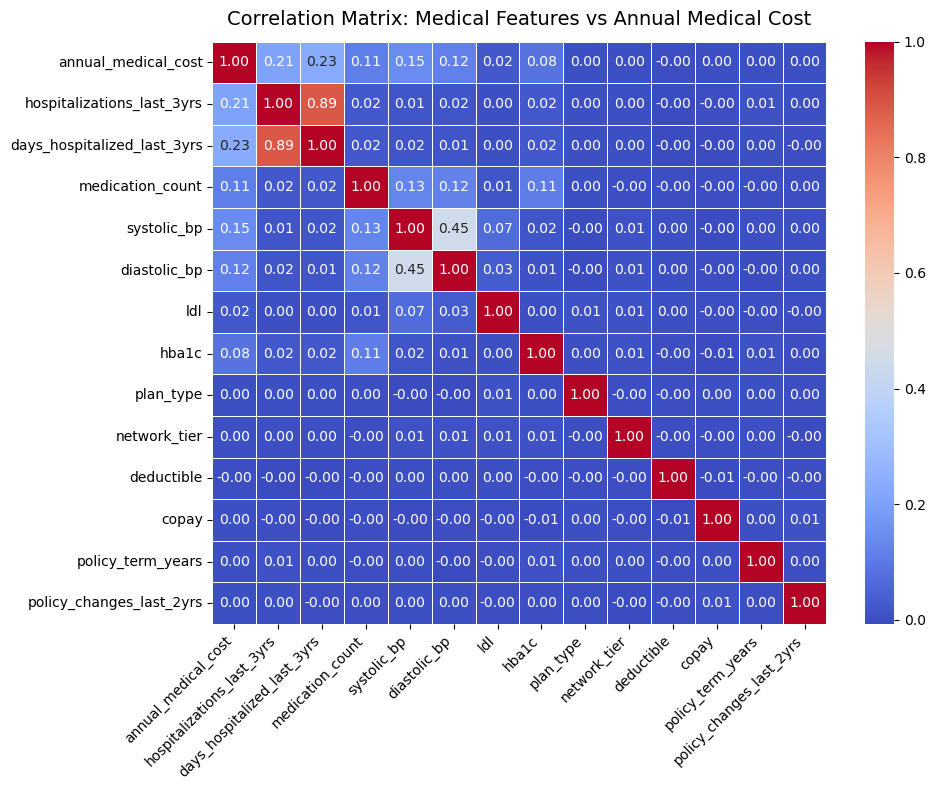

In [43]:
cols = [
    'annual_medical_cost', "hospitalizations_last_3yrs", "days_hospitalized_last_3yrs", "medication_count", "systolic_bp",
    "diastolic_bp", "ldl", "hba1c", 
    "plan_type", "network_tier", "deductible",
    "copay", "policy_term_years", "policy_changes_last_2yrs"
]

df_encoded = df[cols].copy() 

categorical_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'object']

for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes


for col in df_encoded.columns:
    if pd.api.types.is_numeric_dtype(df_encoded[col]):
        continue  # keep numeric columns as-is
    else:
        # Convert categorical / object / Interval to numeric codes
        df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Now compute correlation
corr = df_encoded.corr()


#corr = df[cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: Medical Features vs Annual Medical Cost', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [46]:
target_corr = corr['annual_medical_cost'].drop('annual_medical_cost').sort_values(ascending=False)

print("FEATURES BY CORRELATION WITH TARGET:")
for feature, corr_value in target_corr.items():
    print(f"{feature:25} : {corr_value:6.3f}")

relevant_features = target_corr[abs(target_corr) > 0.1].index.tolist()
print("\nFEATURES WITH |r| > 0.1:")
for feature in relevant_features:
    print(f"{feature:25} : {target_corr[feature]:6.3f}")


df_encoded = df[cols].copy()
categorical_cols = [col for col in df_encoded.columns if df_encoded[col].dtype == 'object']

for col in categorical_cols:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

significant_features = []
for feature in cols[1:]:
    corr_coef, p_value = pearsonr(df_encoded[feature], df_encoded['annual_medical_cost'])
    if p_value < 0.05:
        significant_features.append((feature, corr_coef, p_value))


#significant_features = []
#for feature in cols[1:]:
#    corr_coef, p_value = pearsonr(df[feature], df['annual_medical_cost'])
#    if p_value < 0.05:
#        significant_features.append((feature, corr_coef, p_value))

significant_features.sort(key=lambda x: abs(x[1]), reverse=True)
print("\nSTATISTICALLY SIGNIFICANT FEATURES:")
for feat, corr_val, p_val in significant_features:
    print(f"{feat:25} | {corr_val:10.3f} | {p_val:8.4f}")

high_corr_pairs = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if abs(corr.iloc[i, j]) > 0.7 and cols[i] != cols[j]:
            high_corr_pairs.append((cols[i], cols[j], corr.iloc[i, j]))
#proc_surgery_count should be dropped high mu
print("\nHIGHLY CORRELATED FEATURE PAIRS:")
for feat1, feat2, corr_val in high_corr_pairs:
    print(f"{feat1:25} - {feat2:25} : {corr_val:.3f}")

X = df_encoded[cols[1:]]
y = df_encoded['annual_medical_cost']

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': cols[1:],
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nRANDOM FOREST FEATURE IMPORTANCE:")
for _, row in feature_importance.iterrows():
    print(f"{row['feature']:25} | {row['importance']:.4f}")

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)

feature_scores = pd.DataFrame({
    'feature': cols[1:],
    'f_score': selector.scores_,
    'p_value': selector.pvalues_
}).sort_values('f_score', ascending=False)

print("\nF-TEST FEATURE SCORES:")
for _, row in feature_scores.iterrows():
    print(f"{row['feature']:25} | {row['f_score']:10.2f} | {row['p_value']:8.4f}")

feature_scores_summary = {}
for feature in cols[1:]:
    score = 0
    
    corr_val = abs(target_corr[feature])
    if corr_val > 0.2: score += 3
    elif corr_val > 0.1: score += 2
    elif corr_val > 0.05: score += 1
    
    p_val = feature_scores[feature_scores['feature'] == feature]['p_value'].values[0]
    if p_val < 0.001: score += 3
    elif p_val < 0.01: score += 2
    elif p_val < 0.05: score += 1
    
    rf_rank = feature_importance[feature_importance['feature'] == feature].index[0]
    if rf_rank < 3: score += 2
    elif rf_rank < 6: score += 1
    
    feature_scores_summary[feature] = score

final_scores = sorted(feature_scores_summary.items(), key=lambda x: x[1], reverse=True)

print("\nFINAL FEATURE RANKING:")
for i, (feature, score) in enumerate(final_scores, 1):
    if score >= 4:
        recommendation = "KEEP"
    elif score >= 2:
        recommendation = "KEEP" 
    else:
        recommendation = "DROP"
    print(f"{i:2} | {feature:25} | {score:2} | {recommendation}")

print("\nREDUNDANCY RESOLUTION:")
for feat1, feat2, corr_val in high_corr_pairs:
    corr1 = abs(target_corr[feat1])
    corr2 = abs(target_corr[feat2])
    if corr1 > corr2:
        keep, drop = feat1, feat2
    else:
        keep, drop = feat2, feat1
    print(f"KEEP: {keep:25} | DROP: {drop:25}")

final_features = [feat for feat, score in final_scores if score >= 2]
print(f"\nFINAL FEATURES TO KEEP ({len(final_features)}):")
for feature in final_features:
    print(f"  {feature}")


FEATURES BY CORRELATION WITH TARGET:
days_hospitalized_last_3yrs :  0.230
hospitalizations_last_3yrs :  0.209
systolic_bp               :  0.145
diastolic_bp              :  0.118
medication_count          :  0.113
hba1c                     :  0.083
ldl                       :  0.020
copay                     :  0.003
policy_term_years         :  0.002
plan_type                 :  0.001
policy_changes_last_2yrs  :  0.001
network_tier              :  0.001
deductible                : -0.003

FEATURES WITH |r| > 0.1:
days_hospitalized_last_3yrs :  0.230
hospitalizations_last_3yrs :  0.209
systolic_bp               :  0.145
diastolic_bp              :  0.118
medication_count          :  0.113

STATISTICALLY SIGNIFICANT FEATURES:
days_hospitalized_last_3yrs |      0.230 |   0.0000
hospitalizations_last_3yrs |      0.209 |   0.0000
systolic_bp               |      0.145 |   0.0000
diastolic_bp              |      0.118 |   0.0000
medication_count          |      0.113 |   0.0000
hba1c      

In [49]:
redundant_drops = []
for feat1, feat2, corr_val in high_corr_pairs:
    corr1 = abs(target_corr[feat1])
    corr2 = abs(target_corr[feat2])
    if corr1 > corr2:
        drop = feat2
    else:
        drop = feat1
    redundant_drops.append(drop)

final_features = [feat for feat in final_features if feat not in redundant_drops]

print(f"\nFINAL FEATURES TO KEEP AFTER REMOVING REDUNDANCY ({len(final_features)}):")
for feature in final_features:
    print(f"  {feature}")


FINAL FEATURES TO KEEP AFTER REMOVING REDUNDANCY (6):
  days_hospitalized_last_3yrs
  medication_count
  systolic_bp
  diastolic_bp
  ldl
  hba1c
